# PHY 240: The $e/m$ Experiment
### Nathan Healy, Ben Montgomery, Jacob Mosin

In [1]:
import os, math
import operator
from uncertainties import ufloat
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
font = {'weight' : 'regular',
        'size'   : 18}
matplotlib.rc('font', **font)

from scipy.optimize import curve_fit

from bokeh.models import Label
from bokeh.io import push_notebook, show, output_notebook
from bokeh.plotting import figure
output_notebook()

Loading BokehJS ...

For our experiment, we used the Sargent-Welch 0623B $e/m$ Apparatus. This device consists of two Helmholtz coils, with a large vaccum tube mounted between the coils. Inside the vaccum tube, the is a wire $W$ with five pins on it that bears a straight filliment parallel to the axis of the coils that emits an electrons. This is shown in the diagram as $F$. Surrounding $F$ is a circular anode, $C$, that has a slit $S$ that allows the electrons to escape in the form of a beam. Simultaneously, the Helmholtz coils create a magnetic field, $B$, that acts on the electron beam and causes it to curl.

The device we used can be described by the diagram below.
![title](images/device.png)

Our experimental procedure is as follows:
* Set up the device according to the manufacturer's literature. This includes zeroing instruments, positioning the apparatus in a manner to focus Earth's magnetic field along the $z$ axis alone, and wiring up a sequence of power supplies to seperate drive the electron beam and coils.
* Pick a voltage to run through the coils. We started at $30V$. Additionally, pick a convenient voltage and amperage to run through the fillament in order to get a visible beam.
* Adjust the field current until the electron beam runs perpindicular to the wire in the tube. This indicates that the magnetic feild of the coils is equal to the Earth's field, and as such, is a constant offset for this dataset. All future measurements for current on this voltage will have this current subtracted from them.
* Vary the current through the coils in order to hit "just before" and "just after" the position of each pin. Average this data by pin in an elementwise fashion in order to get an estimate of where the pins actually are.
* Repeat this process, stepping down by decrements of $2.5V$. We stopped after we completed data sampling at $20V$.

In [2]:
# Load data
curr_dir = os.path.join(os.path.dirname(os.path.realpath('__file__')), "EM_data")

val_dict = {}
folder_list = []
for folder in os.listdir(curr_dir):
    for filename in os.listdir(curr_dir + '/' + folder):
        data = pd.read_csv(curr_dir + '/' + folder + '/' + filename, sep="\t")
        data.columns = ["s", "V", "A", "mT"]
        val_dict[folder + filename] = data
    folder_list.append(folder)

all_combos = [(val_dict[folder + 'InitialCurrent.txt'],
               val_dict[folder + 'OuterPin{}.txt'.format(i)],
               val_dict[folder + 'InnerPin{}.txt'.format(i)])
              for folder in folder_list for i in range(1, 6)]

# Define a lambda function for the mean
avr = lambda x,y: (x + y)/2

final_list = []

for (off_df, df1, df2) in all_combos:
    new_df = pd.DataFrame()

    # Go through each Inner, Outer pair and average them element-wise.
    for column_name in df1:
        df1_col = df1[column_name].values
        df2_col = df2[column_name].values
        offset_col = off_df[column_name].values

        # Get the minimum length DF so we don't have indexing errors.
        min_len = min([len(df1_col), len(df2_col), len(offset_col)])

        df1_col, df2_col, offset_col = df1_col[:min_len], df2_col[:min_len], offset_col[:min_len]

        # Our new df has the element-wise avg, minus the static current
        # from our base readings.
        new_df[column_name] = avr(df1_col, df2_col) - offset_col if (column_name == "A") else avr(df1_col, df2_col)

    final_list.append(new_df)

# In the interest of science, have this kicking around.
list_out = [df[['V', 'A', 'mT']].mean(axis=0) for df in final_list]

We know that since we hold $V$ constant, plotting $V$ alone on the Y axis doesn't make a lot of sense. Thus, we opted to graph $2V/R^2$ vs $B^2$, where the slope once again reproduces $e/m$.

Well, now we seperate our data and try plotting it. All 2807 points. The results are rather unconvincing, though, as the Bokeh interactive graph below demonstrates. The green lines right next to the linear fit is the 1-$\sigma$ standard deviation, but you'll notice that they in no way represent the data spread we have. For some non-obvious reason, we've been given a completely garbage result. Time to try and figure out where we went wrong.

In [3]:
# Define the equation defining the B-field of our device.
def mag_field(N, mu, a, I):
    return (8*N*mu*I)/(math.sqrt(125)*a)

def fitFunc(m, x, b):
    return m*x + b

# Define the constants we have to work with
accepted_value = 1.76*math.pow(10, 11)  # coulombs/kg
a = 0.33  # Units in meters
N = 72
mu = 4*math.pi*math.pow(10, -7)  # exact number. This is for free space
radius_list = [0.065/2, 0.078/2, 0.090/2, 0.103/2, 0.115/2]  # Also in meters

V_list = [df["V"].tolist() for df in final_list]
I_list = [df["A"].tolist() for df in final_list]
B_list = [list(map(lambda I: mag_field(N, mu, a, I), I_sublist))
          for I_sublist in I_list]
#B_list = [map(lambda x : x/1000, df["mT"].tolist()) for df in final_list]
R_list = []

for i in range(0, len(folder_list) * len(radius_list)):
    # For every voltage and pin, figure out the shortest
    #sets of data so everything aligns.
    min_len = min([len(V_list[i]), len(I_list[i])])
    V_list[i] = V_list[i][:min_len]
    I_list[i] = I_list[i][:min_len]

    # Generate a bunch of occurences of the ith radius.
    R_list.append([radius_list[i%len(radius_list)]]*min_len)
    
x = np.array([b**2 for B_sublist in B_list for b in B_sublist])
y = np.array([(2*v)/(r**2) for V_sublist, R_sublist in zip(V_list, R_list)
              for v, r in zip(V_sublist, R_sublist)])

fitParams, fitCovariances = curve_fit(fitFunc, x, y)
sigma = np.sqrt(np.diag(fitCovariances))

TOOLS="hover,crosshair,pan,wheel_zoom,zoom_in,zoom_out,box_zoom,undo,redo,reset,tap,save,box_select,poly_select,lasso_select,"

p = figure(title="A Faulty Data Reduction For E/M", tools=TOOLS)

p.scatter(x, y)

# now plot the best fit curve and also +- 1 sigma curves
p.line(x, fitFunc(x, fitParams[0], fitParams[1]), color = "#2222aa")
p.line(x, fitFunc(x, fitParams[0] + sigma[0], fitParams[1] - sigma[1]), color = "green")
p.line(x, fitFunc(x, fitParams[0] - sigma[0], fitParams[1] + sigma[1]), color = "green")
p.xaxis.axis_label = 'B^2 (Tesla^2)'
p.yaxis.axis_label = '2V/R^2 (Volts/Meters^2)'

#output_file("color_scatter.html", title="color_scatter.py example")
show(p, notebook_handle=True)

Try again. This time, let's forget about the standard deviation and look at the error on our data. Are our data groupings belivable, given how their errors do or do not overlap?

(Hint: more garbage data. You'll notice the errors on each cluster are off by themselves, floating in isolation from all those other data clusters that should be overlapping.)

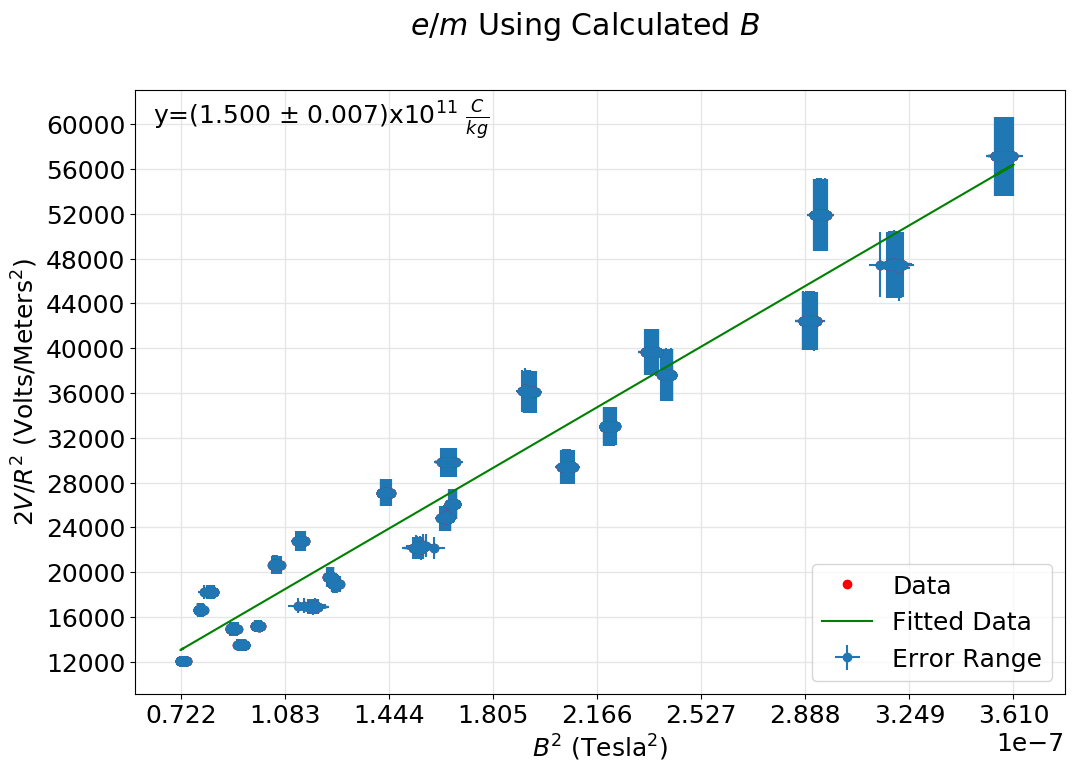

Polyfit with m=1.500e+11+/-6.711e+08
Intercept is  2255.27179991
Experimental Error is 14.783275475224045%
Graph has 2807 datapoints.


In [4]:
V_list = [df["V"].tolist() for df in final_list]
I_list = [df["A"].tolist() for df in final_list]
B_list = [list(map(lambda I: mag_field(N, mu, a, I), I_sublist))
          for I_sublist in I_list]
#B_list = [list(map(lambda x : x/1000, df["mT"].tolist())) for df in final_list]

# Get the errs for B, V, I.
B_err = [(max(B_sublist) - min(B_sublist))/2 for B_sublist in B_list]
V_err = [(max(V_sublist) - min(V_sublist))/2 for V_sublist in V_list]
I_err = [(max(I_sublist) - min(I_sublist))/2 for I_sublist in I_list]
R_list = []

for i in range(0, len(folder_list) * len(radius_list)):
    # For every voltage and pin, figure out the shortest
    #sets of data so everything aligns.
    min_len = min([len(V_list[i]), len(I_list[i])])
    V_list[i] = V_list[i][:min_len]
    I_list[i] = I_list[i][:min_len]

    # Generate a bunch of occurences of the ith radius.
    R_list.append([radius_list[i%len(radius_list)]]*min_len)

# Generate our x,y lists
x = [ufloat(b, B_suberr)**2 for B_sublist, B_suberr in zip(B_list, B_err) for b in B_sublist]
y = [(2*ufloat(v, V_suberr))/(ufloat(r, 0.001)**2)
     for V_sublist, V_suberr, R_sublist in zip(V_list, V_err, R_list)
     for v, r in zip(V_sublist, R_sublist)]

x_vals = [x_val.n for x_val in x]
x_errs = [x_val.s for x_val in x]

y_vals = [y_val.n for y_val in y]
y_errs = [y_val.s for y_val in y]

# Fit our data and get 1 sigma std. deviation from it.
popt, pcov = np.polyfit(x_vals, y_vals, 1, cov=True)
perr = np.sqrt(np.diag(pcov))

# Actually plot out data
fig = plt.figure(figsize=(12,8), dpi=100, facecolor='w', edgecolor='k')
ax = fig.gca()
ax.set_xticks(np.arange(0, 1.1*max(x_vals), (max(x_vals)/10)))
ax.set_yticks(np.arange(0, 1.1*max(y_vals), 4000))
ax.errorbar(x_vals, y_vals, yerr=y_errs, xerr=x_errs, fmt='o', label='Error Range')

fig.suptitle('$e/m$ Using Calculated $B$')
plt.plot(x_vals, y_vals, 'ro', label='Data')
plt.plot(x_vals, np.polyval(popt, x_vals), 'g-', label='Fitted Data')

plt.xlabel('$B^2$ (Tesla$^2$)')
plt.ylabel('$2V/R^2$ (Volts/Meters$^2$)')
plt.grid(color='0.9', linestyle='-', linewidth=1)
ax.legend(loc='lower right')

plt.text(0.2, 0.95,r'y=(1.500 $\pm$ 0.007)x$10^{11}$ $\frac{C}{kg}$', ha='center', va='center', transform=ax.transAxes)
plt.show()
fig.savefig('raw-out.png')

# Print a summary of how good our data is.
print(r"Polyfit with m={:.3e}+/-{:.3e}".format(popt[0], perr[0]))
print("Intercept is ", popt[1])
print("Experimental Error is {1}%"
      .format(popt[0], ((abs(popt[0] - accepted_value)/accepted_value)*100)))
print("Graph has {} datapoints.".format(len(x_vals)))

It turns out we are biasing/manipulating our data by keeping all these points for each cluster. Each cluster, after all, stands for a dataset taken at a given pin at a given voltage. If we average these points, we should get a representation of where these points really are. We aslo don't bias our fit towards one cluster; previously, we had clusters of varying lengths (88-123 points, if I recall correctly), but we are compressing these down to the 1 point they each represent. Our experimental error gets $0.2$% worse, but look at the glory of those sigma values!

In [5]:
# Construct the raw data we'll get each error and V, B, and I list from.
V_data = [df["V"].tolist() for df in final_list]
I_data = [df["A"].tolist() for df in final_list]
B_data = [list(map(lambda I: mag_field(N, mu, a, I), I_sublist))
          for I_sublist in I_data]
#B_data = [list(map(lambda x : x/1000, df["mT"].tolist())) for df in final_list]

# Get the errs for B, V, I.
B_experimental_err = [(max(B_sublist) - min(B_sublist))/2 for B_sublist in B_data]
V_experimental_err = [(max(V_sublist) - min(V_sublist))/2 for V_sublist in V_data]
I_experimental_err = [(max(I_sublist) - min(I_sublist))/2 for I_sublist in I_data]


I_err = [4.9/1000]*len(I_data)
B_err = [0.004/1000]*len(B_data)
V_err = [15/1000]*len(B_data)

B_diff = abs(np.mean(list(map(operator.sub, B_experimental_err, B_err))))
I_diff = abs(np.mean(list(map(operator.sub, I_experimental_err, I_err))))
V_diff = abs(np.mean(list(map(operator.sub, V_experimental_err, V_err))))
print("B avg. experimental error: ", np.mean(B_experimental_err))
print("I avg. experimental error: ", np.mean(I_experimental_err))
print("V avg. experimental error: ", np.mean(V_experimental_err))
print("Diff in B experimental against B provided :", B_diff)
print("Diff in I experimental against I provided :", I_diff)
print("Diff in V experimental against V provided :", V_diff)

# Get averaged values for each data cluster
V_list = [np.mean(df["V"].tolist()) for df in final_list]
B_list = [np.mean(list(map(lambda I: mag_field(N, mu, a, I), I_sublist)))
          for I_sublist in I_data]
I_list = [np.mean(df["A"].tolist()) for df in final_list]

# Populate the R list so we don't have to mess around with mod math when calculating Y later on.
R_list = [radius_list[i%len(radius_list)] for i in range(0, len(folder_list) * len(radius_list))]

# Generate our x, y lists
x = [ufloat(b, B_suberr)**2 for b, B_suberr in zip(B_list, B_err)]
y = [(2*ufloat(v, V_suberr))/(ufloat(r, 0.001)**2)
     for v, V_suberr, r in zip(V_list, V_err, R_list)]

# Pull them apart into value, error pairs.
x_vals = np.array([x_val.n for x_val in x])
x_errs = [x_val.s for x_val in x]

y_vals = np.array([y_val.n for y_val in y])
y_errs = [y_val.s for y_val in y]

# Fit our data and get 1 sigma std. deviation from it.
popt, pcov = np.polyfit(x_vals, y_vals, 1, cov=True)
perr = np.sqrt(np.diag(pcov))

values = np.array([
    fitFunc(x_vals, popt[0] + perr[0], popt[1] + perr[1]), 
    fitFunc(x_vals, popt[0] + perr[0], popt[1] - perr[1]),   
    fitFunc(x_vals, popt[0] - perr[0], popt[1] + perr[1]), 
    fitFunc(x_vals, popt[0] - perr[0], popt[1] - perr[1])])
fitError = np.std(values, axis=0)

B avg. experimental error:  2.50310627755e-06
I avg. experimental error:  0.0127589779923
V avg. experimental error:  0.049273681637
Diff in B experimental against B provided : 1.49689372245e-06
Diff in I experimental against I provided : 0.00785897799226
Diff in V experimental against V provided : 0.034273681637


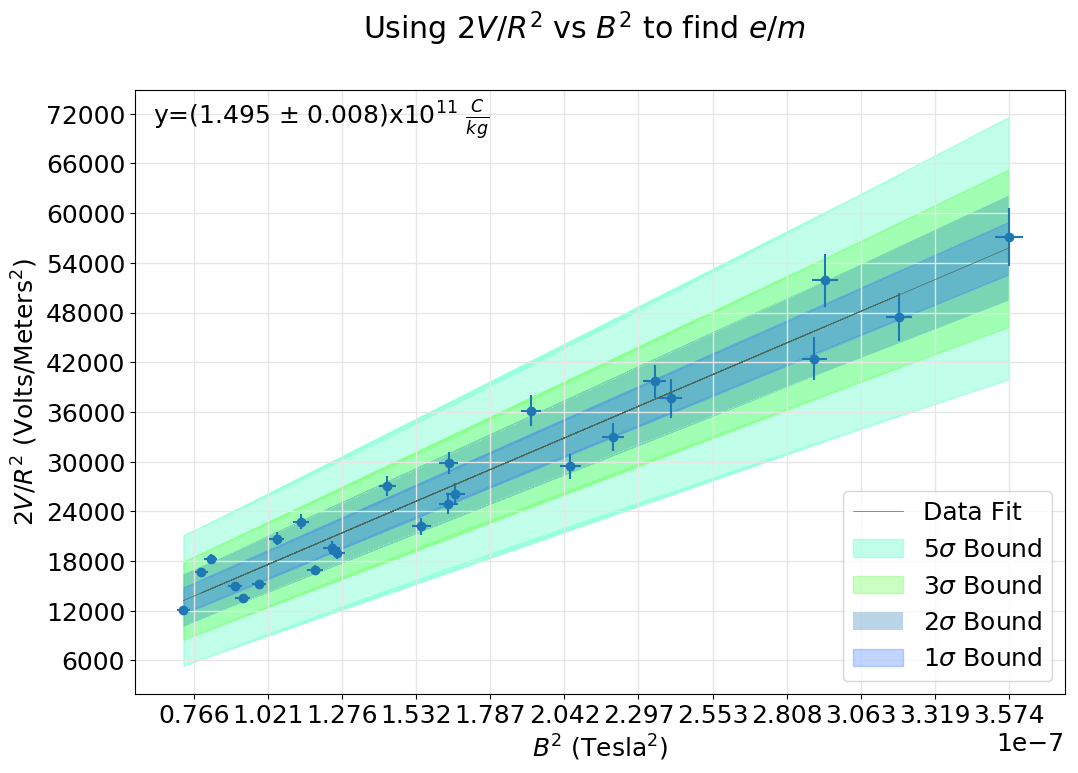

Polyfit with m=1.495e+11+/-7.843e+09
2 sigma: 1.569e+10
3 sigma: 2.353e+10
Intercept is  2327.08322423
Experimental Error is 15.034463950726787%
Graph has 25 datapoints.


In [6]:
# Actually plot out data
fig = plt.figure(figsize=(12,8), dpi=100, facecolor='w', edgecolor='k')
ax = fig.gca()
ax.set_xticks(np.arange(0, 1.3*max(x_vals), (max(x_vals)/14)))
ax.set_yticks(np.arange(0, 1.3*max(y_vals), 6000))

# Plot data and errors
ax.errorbar(x_vals, y_vals, yerr=y_errs, xerr=x_errs, fmt='o')

fig.suptitle('Using $2V/R^2$ vs $B^2$ to find $e/m$')

# Plot the bounds of the 1 sigma std. deviation
y_fit = np.polyval(popt, x_vals)

ax.fill_between(x_vals, y_fit - 5*fitError, y_fit + 5*fitError, color = '#33ffbd', alpha = 0.3, label='5$\sigma$ Bound')
ax.fill_between(x_vals, y_fit - 3*fitError, y_fit + 3*fitError, color = '#55ff33', alpha = 0.3, label='3$\sigma$ Bound')
ax.fill_between(x_vals, y_fit - 2*fitError, y_fit + 2*fitError, alpha = 0.3, label='2$\sigma$ Bound')
ax.fill_between(x_vals, y_fit - fitError, y_fit + fitError, color = '#3374ff', alpha = 0.3, label='1$\sigma$ Bound')

# Plot fit
plt.plot(x_vals, np.polyval(popt, x_vals), '#4b6a5d', linewidth=0.5, label='Data Fit')


plt.xlabel('$B^2$ (Tesla$^2$)')
plt.ylabel('$2V/R^2$ (Volts/Meters$^2$)')
plt.grid(color='0.9', linestyle='-', linewidth=1)
ax.legend(loc='lower right')
plt.text(0.2, 0.95,r'y=(1.495 $\pm$ 0.008)x$10^{11}$ $\frac{C}{kg}$', ha='center', va='center', transform=ax.transAxes)

plt.show()
fig.savefig('out.png')

# Print a summary of how good our data is.
print(r"Polyfit with m={:.3e}+/-{:.3e}".format(popt[0], perr[0]))
print("2 sigma: {:.3e}".format(2*perr[0]))
print("3 sigma: {:.3e}".format(3*perr[0]))
print("Intercept is ", popt[1])
print("Experimental Error is {1}%"
      .format(popt[0], ((abs(popt[0] - accepted_value)/accepted_value)*100)))
print("Graph has {} datapoints.".format(len(x_vals)))

In [7]:
# Cool. Now, let's find out what contributed the most to our error.